# Advanced Tutorial: Multi-Panel Integration and Downstream Analysis with CytoVI

In this tutorial, we demonstrate advanced functionality of **CytoVI**, a deep generative model for protein expression measurements from technologies such as flow cytometry, mass cytometry, or CITE-seq. Building on the quick start tutorial, we now explore how CytoVI can be used to integrate multiple cytometry panels, impute missing markers, transfer annotations between datasets, and uncover biological differences through differential expression and abundance analysis.

If you are new to CytoVI or unfamiliar with data loading, preprocessing, or training the model, we recommend starting with the [quick start tutorial](./CytoVI_batch_correction_tutorial.ipynb) where these fundamental steps are introduced in detail. In this tutorial, we will work with preprocessed and partially annotated data to focus on the advanced use cases of the model.

Specifically, we analyze conventional flow cytometry data of tumor-infiltrating T cells obtained from patients with B-cell non-Hodgkin lymphoma (BNHL). These samples were profiled using two distinct antibody panels, which share a subset of common markers. Using CytoVI, we will integrate both panels into a shared representation space, infer missing marker expression, and perform downstream biological analysis to gain insights into T cell heterogeneity across patients.

Plan for this tutorial:

1. Load and inspect preprocessed data
2. Train a CytoVI model that integrates both antibody panels
3. Visualize the joint latent space and evaluate panel integration
4. Impute non-overlapping protein markers and assess imputation quality
5. Automatically annotate immune cell types via label transfer
6. Quantify differential protein expression across clusters
7. Detect disease-associated T cell states using label-free differential abundance analysis

In [1]:
# Install from GitHub for now
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/scvi_colab/_core.py:42: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import ContextualVersionConflict
/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import random
import tempfile
import requests
import scvi

import numpy as np  # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import scanpy as sc  # type: ignore
from scvi.external import cytovi # type: ignore
import torch  # type: ignore
from rich import print  # type: ignore
from sklearn.cluster import KMeans # type: ignore
from scipy.stats import mannwhitneyu

os.environ['SCIPY_ARRAY_API'] = '1'

sc.set_figure_params(figsize=(4, 4))

scvi.settings.seed = 0
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.2

## Loading the data

In this tutorial, we will work with a curated, lightweight subset of flow cytometry data from the BNHL study by Roider et al. 2024 (Nature Cell Biology, https://doi.org/10.1038/s41556-024-01358-2). The dataset includes flow cytometry measurements of T cells from 33 donors across two distinct antibody panels, each profiling 12 protein markers along with morphological features such as forward and side scatter (FSC and SSC). Samples were acquired across four independent experimental batches. For ease of use, the data have been preprocessed to correct for fluorescent spillover, restricted to live single-cell events, and transformed using a hyperbolic arcsin transformation, scaled and subsampled to ~5000 cells per panel. We will access the dataset as preprocessed .h5ad files. For demonstration purposes data from one of the panels comes with cell type annotations.

In [3]:
temp_dir_obj = tempfile.TemporaryDirectory()

adata_p1_path = os.path.join(temp_dir_obj.name, "Roider_et_al_BNHL_panel1.h5ad")
adata_p1 = sc.read(adata_p1_path, backup_url='https://figshare.com/ndownloader/files/56891468')

adata_p2_path = os.path.join(temp_dir_obj.name, "Roider_et_al_BNHL_panel2.h5ad")
adata_p2 = sc.read(adata_p2_path, backup_url='https://figshare.com/ndownloader/files/56891471')

  0%|          | 0.00/2.42M [00:00<?, ?B/s]

  0%|          | 0.00/1.89M [00:00<?, ?B/s]

In [4]:
adata_p1

AnnData object with n_obs × n_vars = 4983 × 14
    obs: 'sample_id', 'PatientID', 'batch', 'panel', 'Entity', 'cell_type'
    layers: '_nan_mask', 'raw', 'scaled', 'transformed'

As the data has been preprocessed already, we can directly merge the two panels into one anndata object using `cytovi.merge_batches()`. This will automatically register a `nan_layer` that will handle the modeling of missing markers under the hood.

In [5]:
adata = cytovi.merge_batches([adata_p1, adata_p2], batch_key='panel_batch')
adata

/tmp/ipykernel_2682174/3116451448.py:1: UserWarning: Not all proteins are detected across all batches. Will generate nan_layer for imputation of missing proteins. 
Backbone markers: CD3, CD4, CD45RA, CD69, CD8, FSC-A, FoxP3, Ki67, PD1, SSC-A
  adata = cytovi.merge_batches([adata_p1, adata_p2], batch_key='panel_batch')
/home/projects/amit/floriani/github_repos/scvi-tools-cytovi/src/scvi/external/cytovi/_preprocessing.py:255: UserWarning: Masking layer _nan_mask already exists. Overwriting it.
  adata = register_nan_layer(


AnnData object with n_obs × n_vars = 9966 × 18
    obs: 'sample_id', 'PatientID', 'batch', 'panel', 'Entity', 'cell_type', 'panel_batch'
    var: '_batch_0', '_batch_1'
    layers: '_nan_mask', 'raw', 'scaled', 'transformed'

Inspection of the histograms for each marker demonstrates that some proteins, such as CD4, CD3, CD45RA, CD69, were detected in both antibody panels, while four markers were unique to batch one (e.g. CD25, CXCR5) and four additional markers were unique to batch two (e.g. CD244 and TIM-3).

/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate

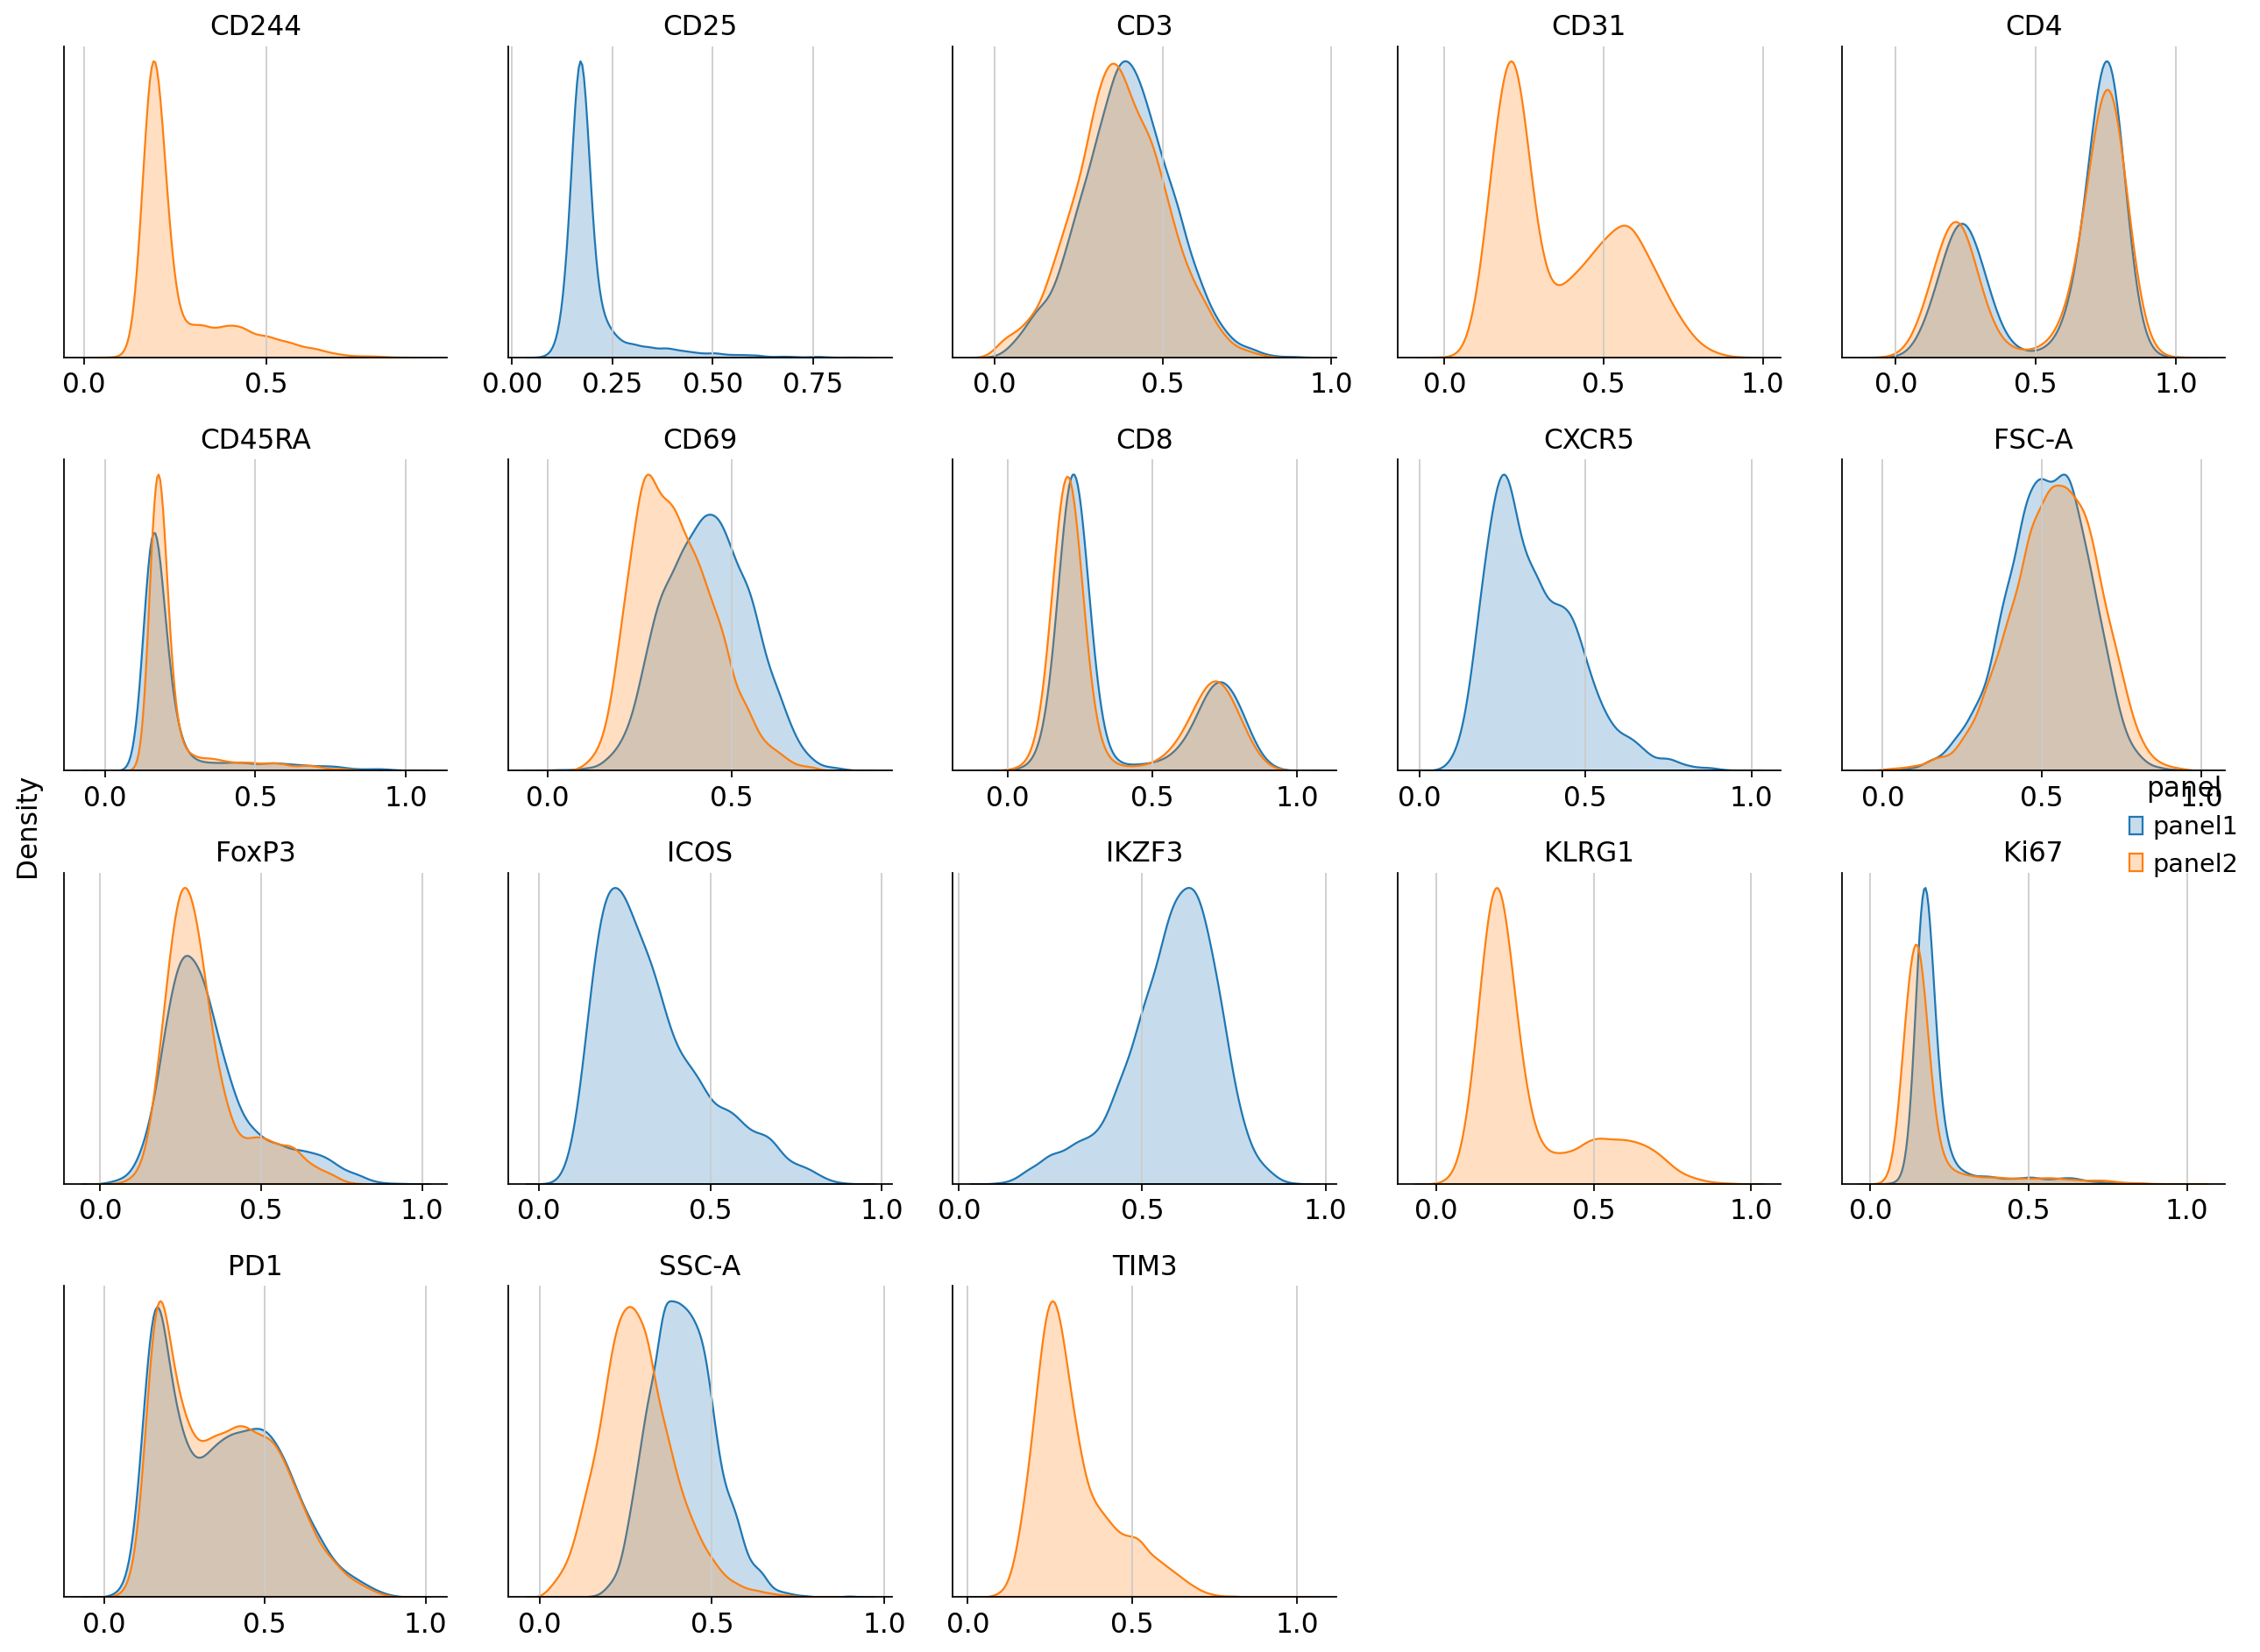

In [6]:
cytovi.plot_histogram(adata, layer_key='scaled', groupby='panel')

Additionally, we see that CD69 demonstrates a batch effect in one of the four batches.

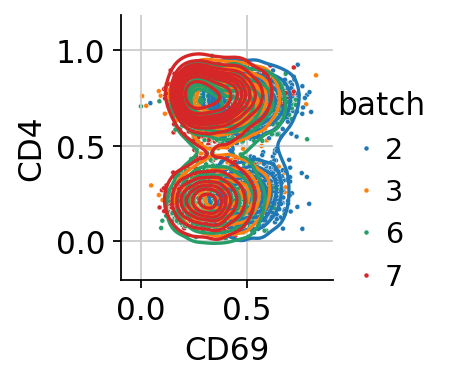

In [7]:
cytovi.plot_biaxial(adata, marker_x='CD69', marker_y='CD4', layer_key='scaled', color='batch')

## Training a CytoVI model

In the next step, we will train a CytoVI model to control for technical variation between the batches. As our dataset consists of multiple patients of different B cell lymphoma diagnoses, we will additionally specify a `sample_key`, which will be used for downstream application such as performing differential expression across patients or for the identification of disease-associated T cell states. If using CytoVI's `cytovi.merge_batches` function to combine both panels, CytoVI will automatically register a `nan_layer` and handle imputation of missing proteins. In this case only the shared backbone markers are encoded into the latent representation, while the decoder network reconstructs the full protein panel.

In [8]:
cytovi.CYTOVI.setup_anndata(adata, layer='scaled', batch_key='batch', sample_key='PatientID')
model = cytovi.CYTOVI(adata)
model.train(n_epochs_kl_warmup=50)

/tmp/ipykernel_2682174/2727971273.py:1: UserWarning: Found nan_layer in adata. Will register nan_layer for missing marker imputation.
  cytovi.CYTOVI.setup_anndata(adata, layer='scaled', batch_key='batch', sample_key='PatientID')
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 30 records. Best score: -14.932. Signaling Trainer to stop.


In [9]:
model

CytoVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, 
protein_likelihood: normal, latent_distribution: normal, 
MoG prior: True, n_labels 1, n_proteins: 18, 
Impute missing markers: True, 
Backbone markers: CD3, CD4, CD45RA, CD69, CD8, FSC-A, FoxP3, Ki67, PD1, SSC-A
Training status: Trained

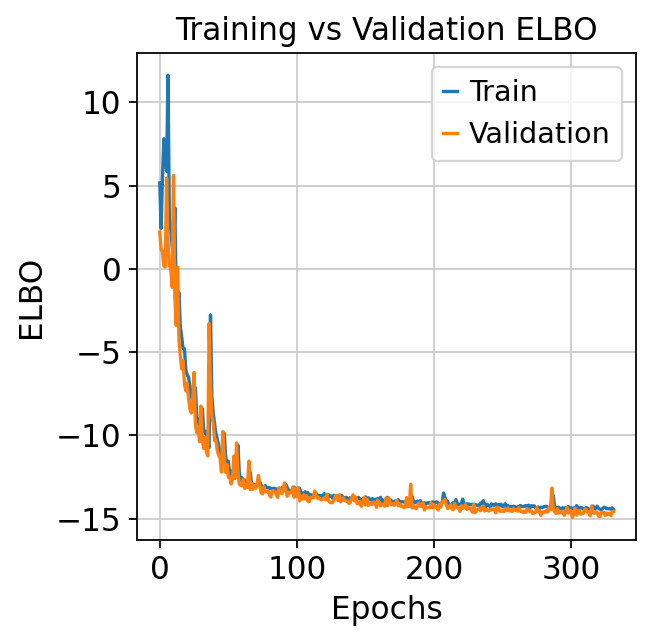

In [10]:
plt.plot(model.history['elbo_train'], label='Train')
plt.plot(model.history['elbo_validation'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.legend()
plt.title('Training vs Validation ELBO')
plt.show()

## Visualize the joint latent space

Next, we get the latent representation of our cells while controlling for batch and panel variation and visualize the joint latent space using UMAP.

/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: FutureWarning: `method='rapids'` is deprecated. Use `rapids_singlecell.tl.louvain` instead.
  return fn(*args_all, **kw)


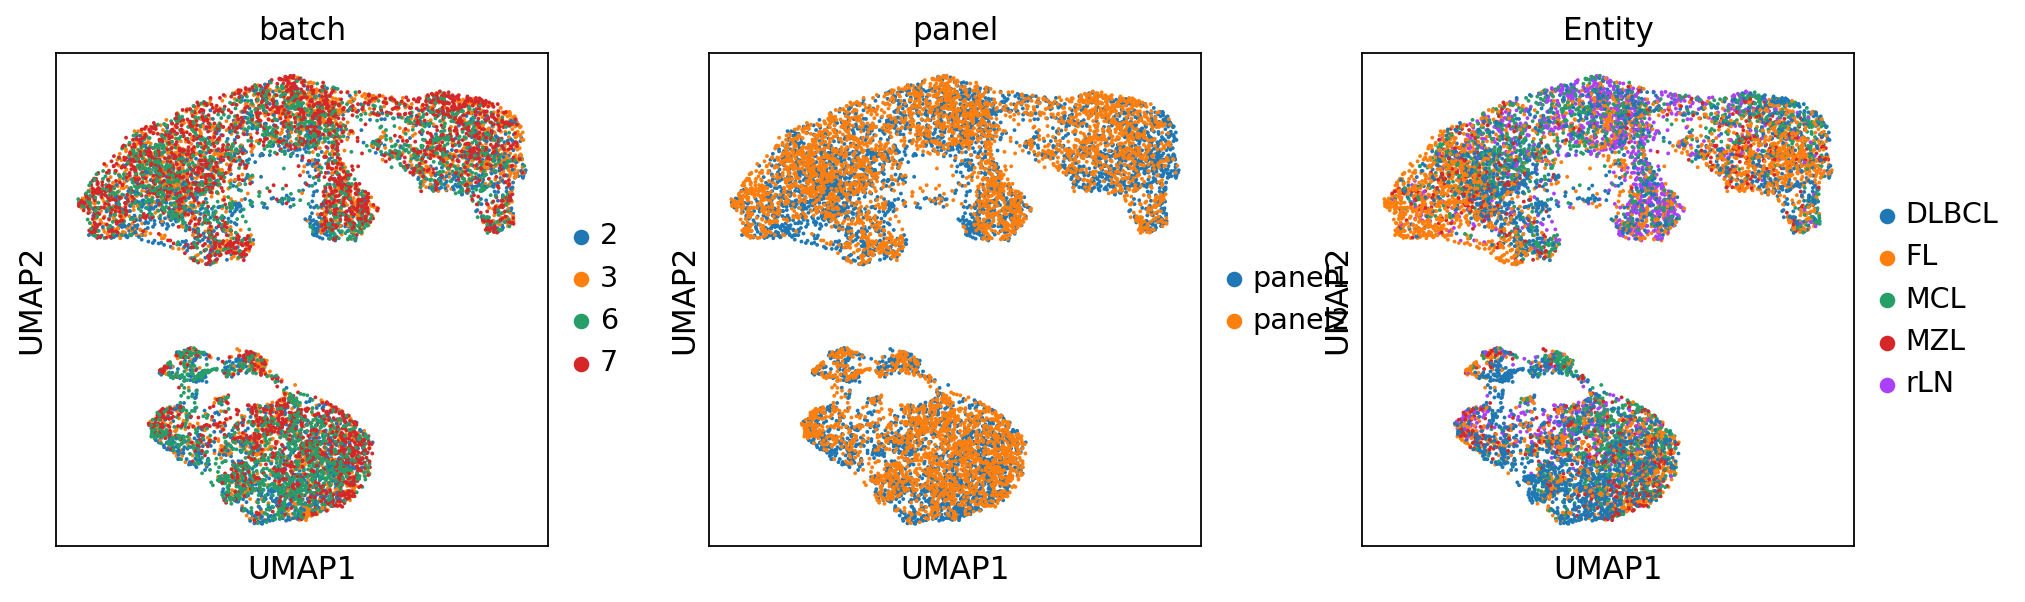

In [11]:
adata.obsm['X_CytoVI'] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep='X_CytoVI', transformer='pynndescent')
sc.tl.umap(adata, min_dist=0.4)
sc.pl.umap(adata, color = ['batch', 'panel', 'Entity'])

We can see that this latent representation effectively controlled for batch and panel variation and yielded a cell representation that still maintains the variability between the different disease entities.

## Impute non-overlapping protein markers

Next, we obtain the batch corrected protein expression from the CytoVI model that automatically imputes non-overlapping protein markers. Here, we will sample ten times from the posterior distribution and generate the imputed protein expression ten times in order to assess the imputation uncertainty. We take the mean over these ten samples as our estimate for the imputed protein expression.

In [12]:
imp_expr = model.get_normalized_expression(n_samples=10, return_mean = False)
adata.layers['imputed'] = imp_expr.mean(axis=0).copy()

/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/torch/utils/_contextlib.py:116: UserWarning: detected missing proteins between batches - will impute missing markers
  return func(*args, **kwargs)


Inspection of the marker histograms now shows the complete imputed protein expression for all proteins present in the combined set of the two antibody panels. Additionally, we can now query markers that were unique for each of the panels, and display for example the expression of the costimulatory protein CD244 versus the IL-2 high affinity chain CD25.

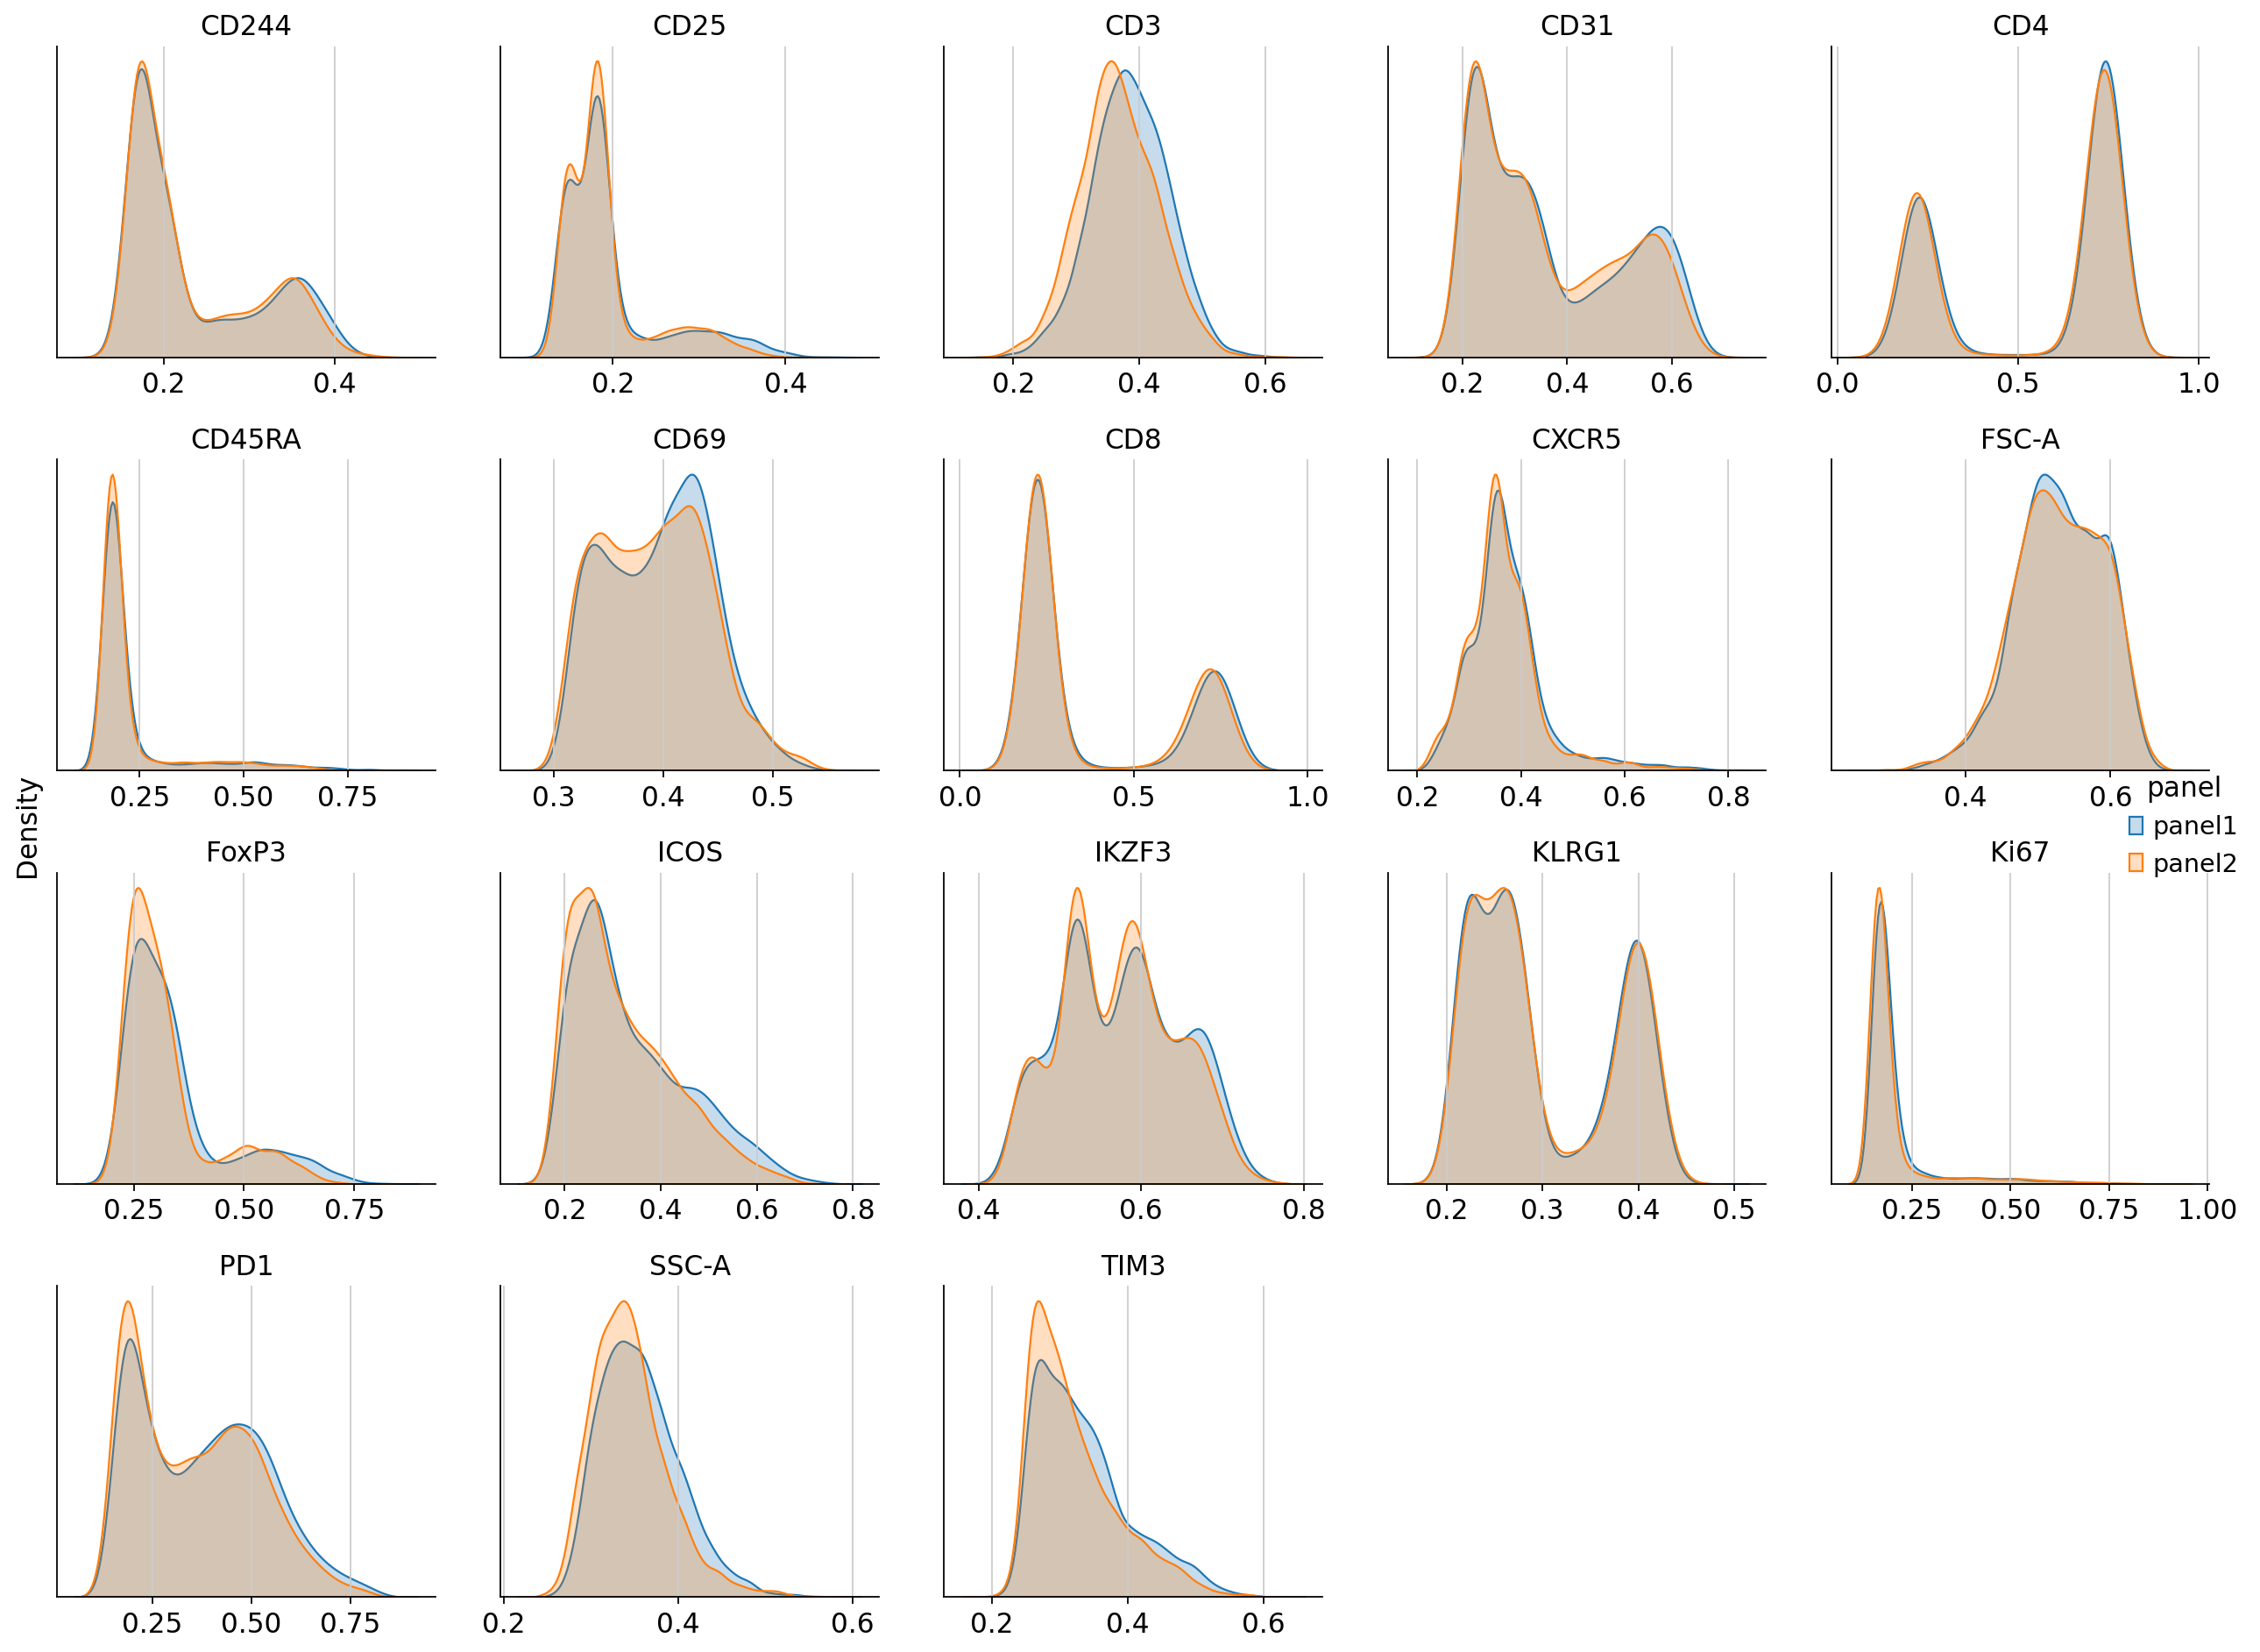

In [13]:
cytovi.plot_histogram(adata, layer_key='imputed', groupby='panel')

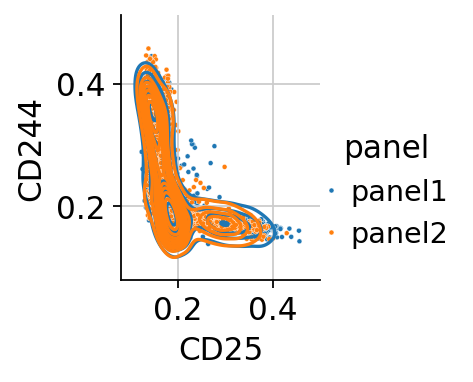

In [14]:
cytovi.plot_biaxial(adata, marker_x='CD25', marker_y='CD244', layer_key='imputed', color='panel')

Next, we compute the coefficient of variation across the ten imputed expression estimates as a measure of uncertainty of the posterior samples and visualize the uncertainty across the cell and feature axes to judge imputation performance.

In [15]:
adata.layers['imputed_cv'] = 100*imp_expr.std(axis=0).copy()/imp_expr.mean(axis=0).copy()

adata.var['var_imp_uncertainty'] = adata.layers['imputed_cv'].mean(axis=0).copy()
adata.obs['obs_imp_uncertainty'] = adata.layers['imputed_cv'].mean(axis=1).copy()

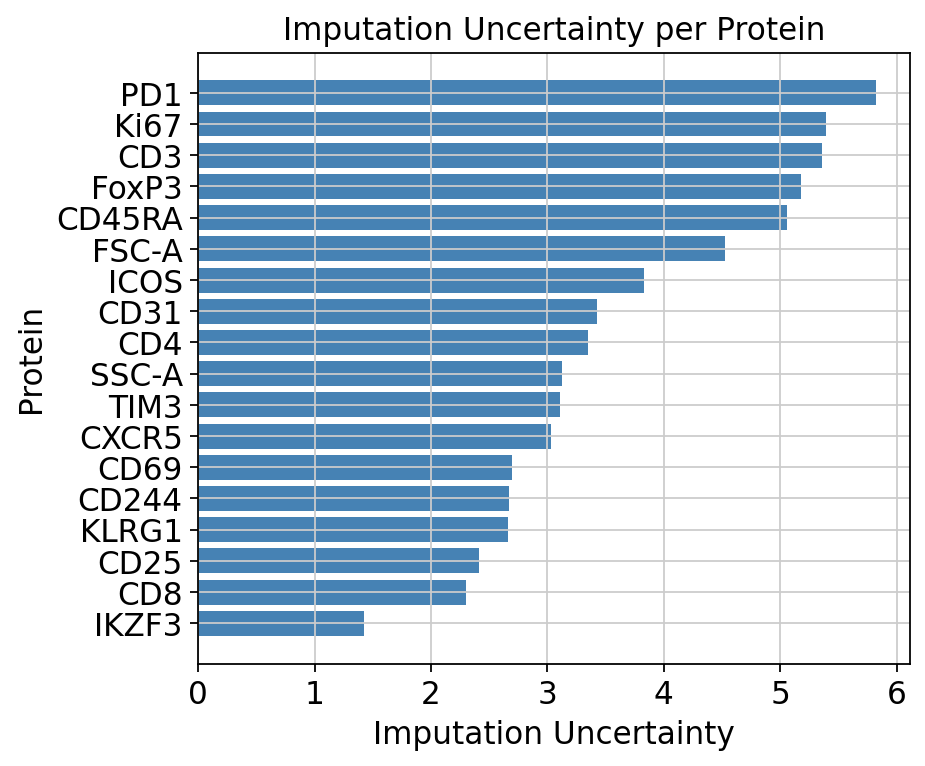

In [16]:
uncertainty = adata.var['var_imp_uncertainty'].sort_values()

plt.figure(figsize=(6, 5))
plt.barh(uncertainty.index, uncertainty.values, color="steelblue")
plt.xlabel("Imputation Uncertainty")
plt.ylabel("Protein")
plt.title("Imputation Uncertainty per Protein")
plt.tight_layout()
plt.show()

This analysis demonstrated that the model was less certain when imputing Ki67 expression (even though it was measured in both of the panels) compared to CD25 or CD244 that were only measured in one of the panels.

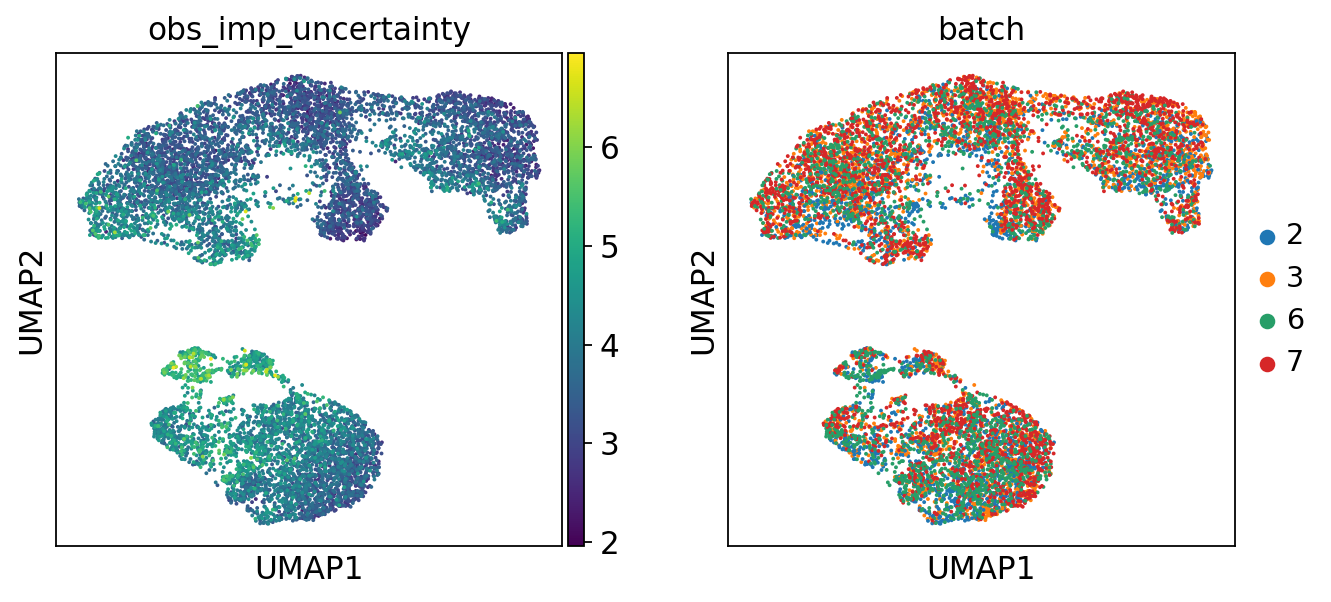

In [17]:
sc.pl.umap(adata, color = ['obs_imp_uncertainty', 'batch'])

Visualizing the aggregated imputation uncertainty per cell provides an estimate of how reliably missing markers can be imputed. In this example, the uncertainty plot reveals that the model is especially uncertain for cells in regions of CytoVI’s latent space where batch representation is imbalanced. This underscores the importance of imputing markers only when integrating biologically comparable studies. 
We can also query and visualize the imputation uncertainty of individual markers to judge how much we can trust the imputation results in downstream analyses.

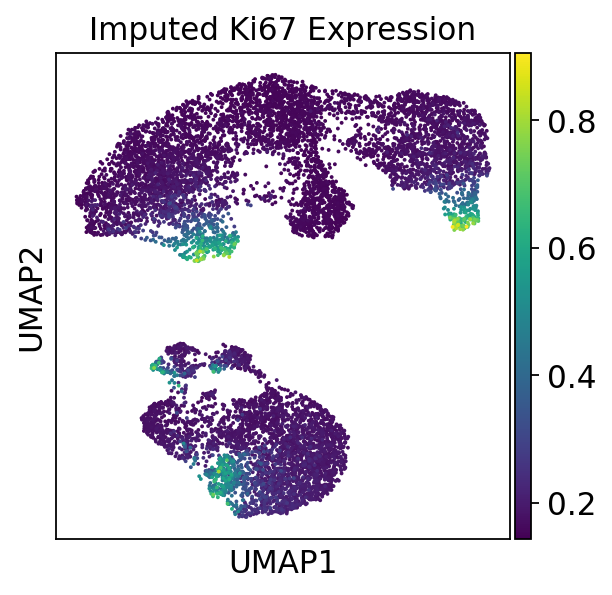

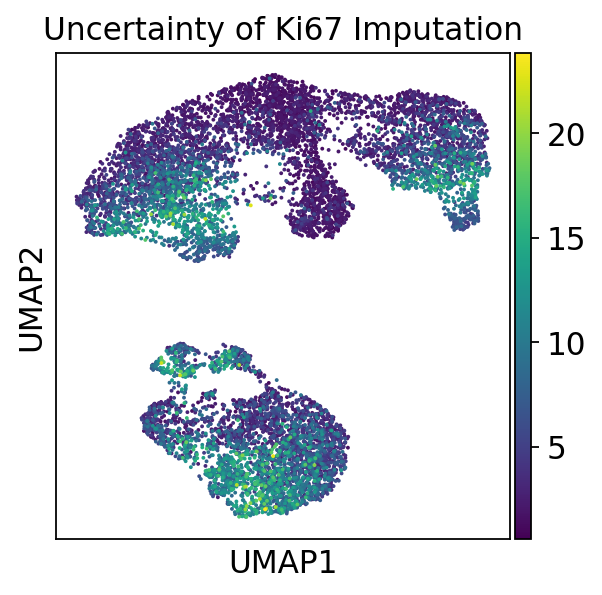

In [18]:
sc.pl.umap(adata, color = 'Ki67', layer='imputed', title ='Imputed Ki67 Expression')
sc.pl.umap(adata, color = 'Ki67', layer='imputed_cv', title='Uncertainty of Ki67 Imputation')

## Label transfer

In our example, cells from one antibody panel were already annotated, whereas data from the second panel lacked annotations. We will demonstrate how the integrated CytoVI latent space can be used to transfer labels—such as cell type annotations—from the annotated panel to the unannotated dataset.

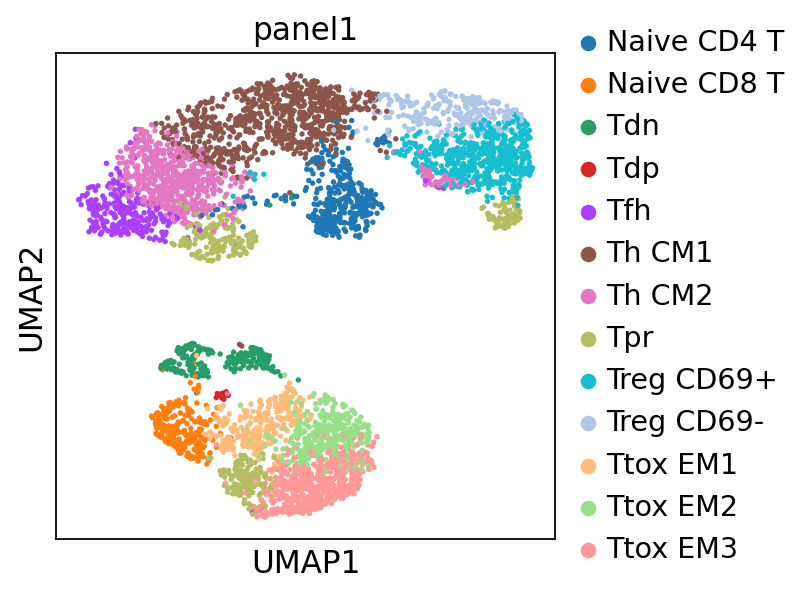

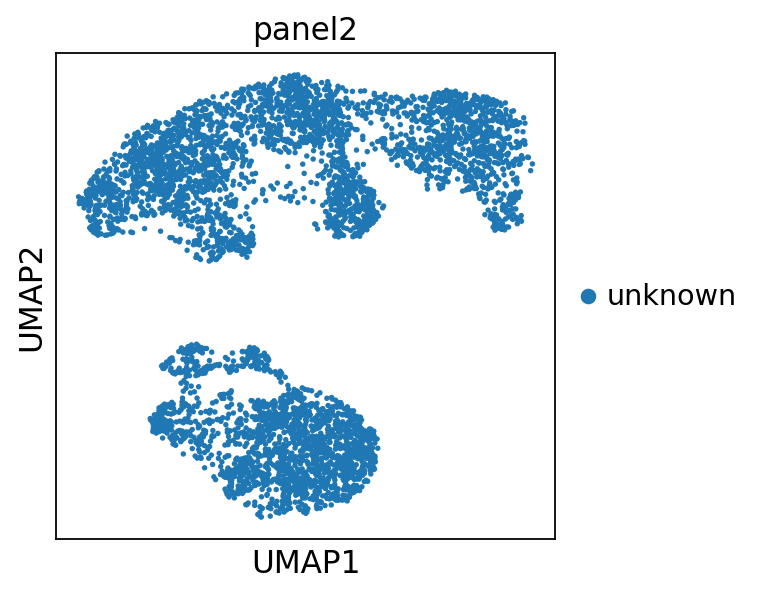

In [19]:
for panel in adata.obs['panel'].drop_duplicates():
    adata_panel = adata[adata.obs['panel'] == panel].copy()
    sc.pl.umap(adata_panel, color = 'cell_type', title = panel)

In [20]:
adata_ref = adata[adata.obs['panel'] == 'panel1'].copy()
adata.obs['cell_type_predicted'] = model.impute_categories_from_reference(adata_reference= adata_ref, cat_key='cell_type')

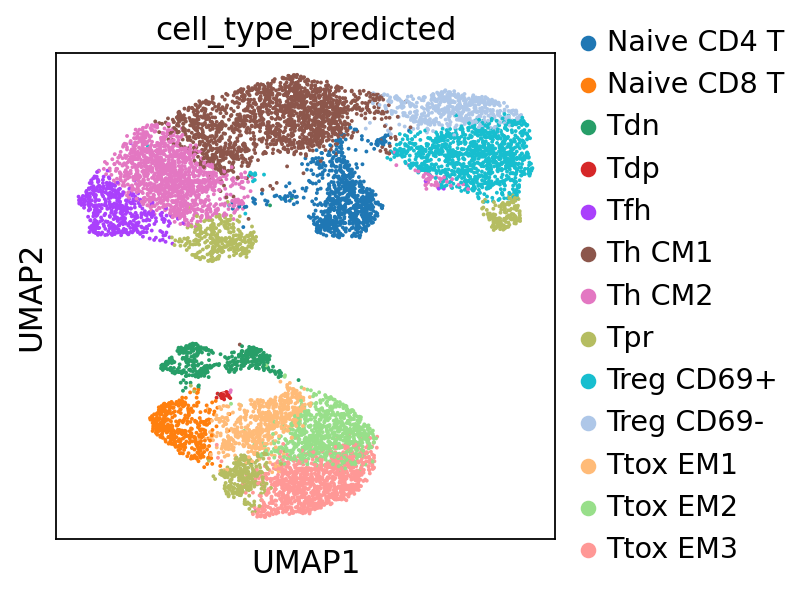

In [21]:
sc.pl.umap(adata, color = 'cell_type_predicted')

Since both antibody panels were applied to the same patients we expect a similar proportion of cell types across both panels and can use this as a quick sanity check.

/tmp/ipykernel_2682174/3396782850.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(['panel', 'cell_type_predicted']).size().unstack().plot(kind='bar', stacked=True)


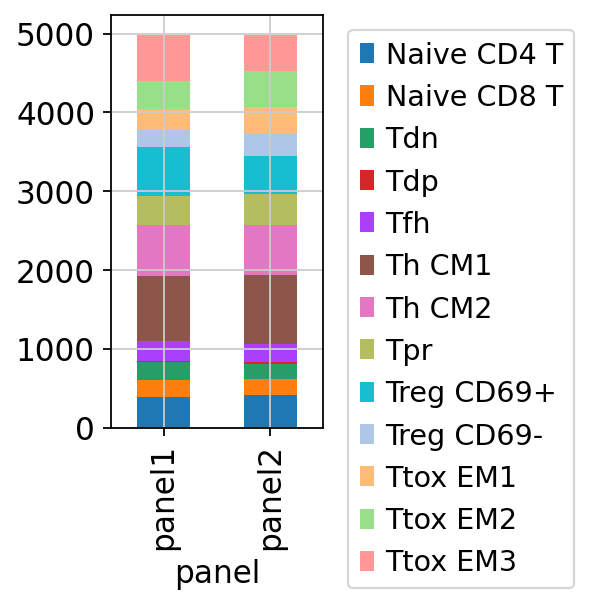

In [22]:
adata.obs.groupby(['panel', 'cell_type_predicted']).size().unstack().plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

We can then visualize the expression profile of the transferred cell type labels across the combined marker space of both antibody panels.

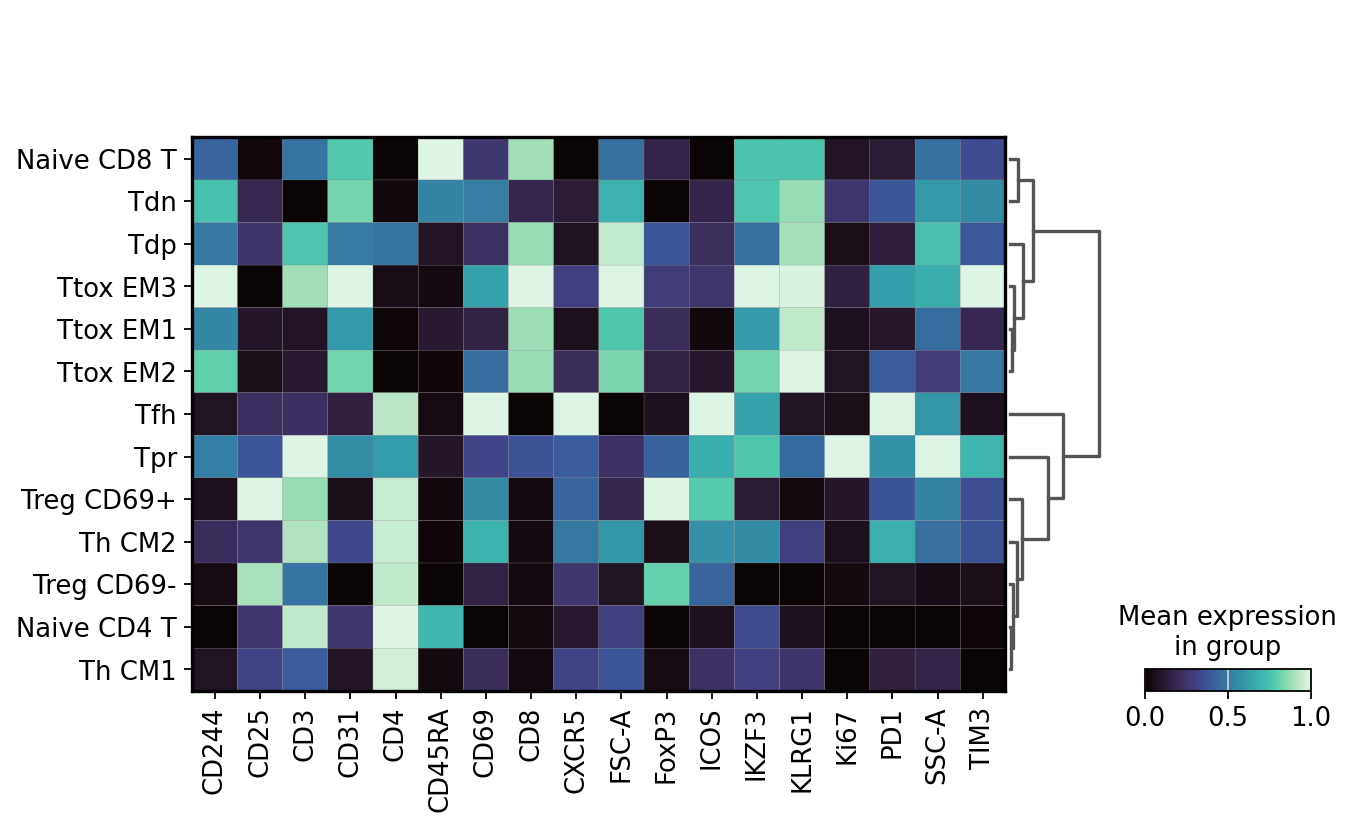

In [23]:
sc.pl.matrixplot(adata, var_names=adata.var_names, groupby="cell_type_predicted", layer='imputed', dendrogram=True, standard_scale='var', cmap = 'mako')

## Differential expression

We can now directly query the generative model to find differentially expressed proteins for each of the transferred cell type labels in relation to all other cells.

In [24]:
de_res = model.differential_expression(groupby='cell_type_predicted', delta=0.1)

/home/projects/amit/floriani/github_repos/scvi-tools-cytovi/src/scvi/external/cytovi/_utils.py:172: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_groups = adata.obs.groupby(sample_key).groups


DE...:   0%|          | 0/13 [00:00<?, ?it/s]

In [25]:
de_res

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
CD45RA    0.9694        0.0306      3.455677  0.423830  0.215382   
PD1       0.9472        0.0528      2.886999  0.172671  0.384764   
CD31      0.9080        0.0920      2.289456  0.303182  0.370023   
ICOS      0.9030        0.0970      2.231011  0.224663  0.341283   
SSC-A     0.9000        0.1000      2.197224  0.293893  0.354877   
...          ...           ...           ...       ...       ...   
CD3       0.8138        0.1862      1.474893  0.413332  0.369051   
IKZF3     0.8000        0.2000      1.386294  0.674209  0.564503   
CXCR5     0.7662        0.2338      1.186977  0.353164  0.369403   
FSC-A     0.7616        0.2384      1.161472  0.600447  0.521588   
CD45RA    0.7312        0.2688      1.000719  0.191293  0.235457   

        pseudocounts  delta  lfc_mean  lfc_median   lfc_std   lfc_min  \
CD45RA       0.00001    0.1  0.989194    1.088524  0.672458 -1.893166   
PD1          0.00001    0.1 -1.053311   -1.170194  0.697713 -2.567554   
CD31         0.00001    0.1 -0.194349   -0.193903  0.627673 -1.807683   
ICOS         0.00001    0.1 -0.536745   -0.509044  0.531630 -2.080377   
SSC-A        0.00001    0.1 -0.302624   -0.275497  0.682009 -2.333021   
...              ...    ...       ...         ...       ...       ...   
CD3          0.00001    0.1  0.184281    0.163675  0.419050 -0.981008   
IKZF3        0.00001    0.1  0.265663    0.258643  0.215560 -0.482426   
CXCR5        0.00001    0.1 -0.045465   -0.035962  0.378450 -1.601252   
FSC-A        0.00001    0.1  0.214997    0.195553  0.271375 -0.716274   
CD45RA       0.00001    0.1 -0.186855   -0.035360  0.582002 -2.608451   

         lfc_max  is_de_fdr_0.05           comparison       group1 group2  
CD45RA  2.375213            True  Naive CD4 T vs Rest  Naive CD4 T   Rest  
PD1     1.568841            True  Naive CD4 T vs Rest  Naive CD4 T   Rest  
CD31    1.808105           False  Naive CD4 T vs Rest  Naive CD4 T   Rest  
ICOS    1.421322           False  Naive CD4 T vs Rest  Naive CD4 T   Rest  
SSC-A   1.824585           False  Naive CD4 T vs Rest  Naive CD4 T   Rest  
...          ...             ...                  ...          ...    ...  
CD3     1.904547           False     Ttox EM3 vs Rest     Ttox EM3   Rest  
IKZF3   0.975654           False     Ttox EM3 vs Rest     Ttox EM3   Rest  
CXCR5   1.330986           False     Ttox EM3 vs Rest     Ttox EM3   Rest  
FSC-A   1.448523           False     Ttox EM3 vs Rest     Ttox EM3   Rest  
CD45RA  1.543247           False     Ttox EM3 vs Rest     Ttox EM3   Rest  

[234 rows x 16 columns]

These results demonstrate that CD45RA is enriched in Naive T helper cells versus all other cells, while PD-1 is decreased, which is in line with our understanding of these marker proteins.

## Label-free differential abundance

Next, we will use CytoVI's label-free differential abundance analysis to automatically detect positions in latent space that are associated with a covariate of interest. In this case we will apply the `model.differential_abundance` method to identify T cell states that are associated with the different lymphoma entities (one versus all). This will for each cell and each lymphoma entity yield a differential abundance (DA) score that estimates how strongly the cell is associated with the respective lymphoma entity compared to all other entities. We can then visualize the DA scores on the latent space to identify regions characteristic for disease.

In [26]:
da_res = model.differential_abundance(groupby='Entity')

100%|██████████| 33/33 [00:02<00:00, 11.99it/s]


In [27]:
da_res

DA_FL    DA_rLN  DA_DLBCL    DA_MZL    DA_MCL
0     0.822143 -0.618047 -1.443803 -1.413024  0.439076
1    -0.417810 -5.734671  1.671362  2.226166 -0.354006
2     1.439313 -0.863187 -1.314026 -0.685320  0.311669
3    -1.042414 -1.299545  2.617706  2.340376  0.586704
4     1.408242 -1.161294 -1.158160 -1.310624  0.044818
...        ...       ...       ...       ...       ...
9961  0.125992 -4.258009  2.859608  3.418985 -0.493542
9962  0.155818  3.319804 -0.418020 -0.956992  0.191376
9963  0.075382  3.237645 -0.480327 -1.588670 -0.417802
9964  1.429568 -3.300817 -0.029801 -0.188125 -0.722513
9965 -0.120546 -3.625765  1.813866  2.135527  0.101460

[9966 rows x 5 columns]

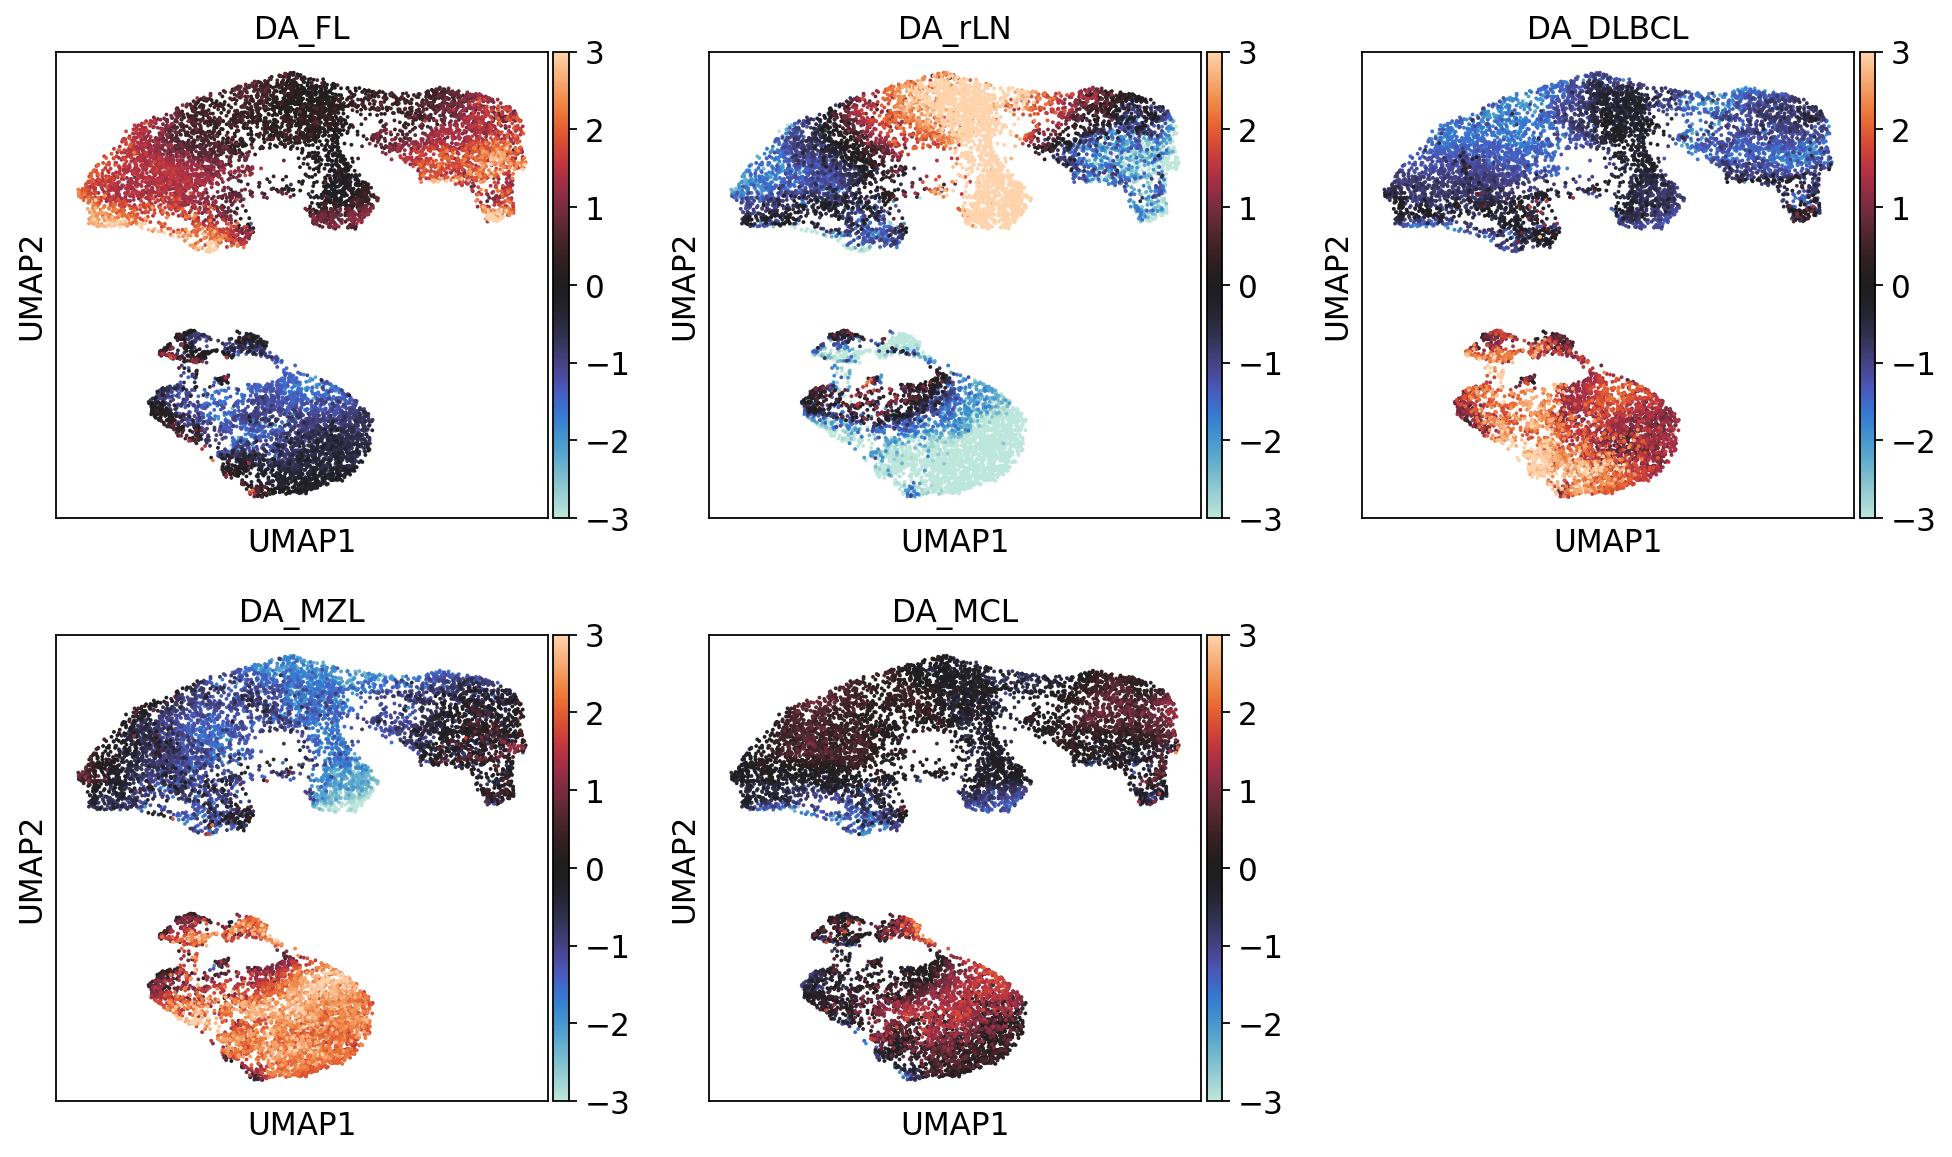

In [28]:
adata.obs = pd.concat([adata.obs, pd.DataFrame(da_res.values, columns=da_res.columns, index=adata.obs.index)], axis=1)
sc.pl.umap(adata, color = da_res.columns, cmap='icefire', ncols=3, vmin=-3, vmax=3)

In a next step we want to use these DA scores to determine differentially abundant clusters that are associated with disease. For this we will concatenate the DA scores for each tumor entity to the CytoVI latent space and perform Kmeans clustering.  

In [29]:
da_latent = np.hstack((da_res, adata.obsm['X_CytoVI']))

kmeans = KMeans(n_clusters=13, random_state=0).fit(da_latent)
adata.obs['da_cluster'] = kmeans.labels_.astype('str')

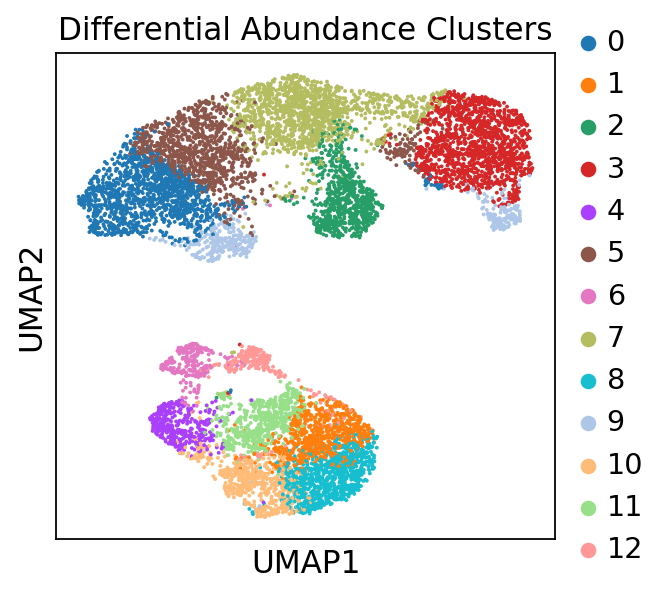

In [30]:
sc.pl.umap(adata, color='da_cluster', title='Differential Abundance Clusters')

Next, we will compute the relative frequency of the DA clusters per patient and test for differential abundance compared to the control group using a Mann-Whitney U test. We will do this for the cluster that showed highest DA scores for follicular lymphoma (FL) patients. Note: in this case it is cluster 0 but it can change depending on the runtime environment of the notebook.

In [31]:
freq_table = adata.obs.groupby(['PatientID', 'da_cluster']).size().unstack(fill_value=0)
freq_table_normalized = freq_table.div(freq_table.sum(axis=1), axis=0)*100
res = pd.merge(freq_table_normalized.reset_index('PatientID'), adata.obs[['PatientID', 'Entity']].drop_duplicates(), on='PatientID')

/tmp/ipykernel_2682174/1556862651.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_table = adata.obs.groupby(['PatientID', 'da_cluster']).size().unstack(fill_value=0)


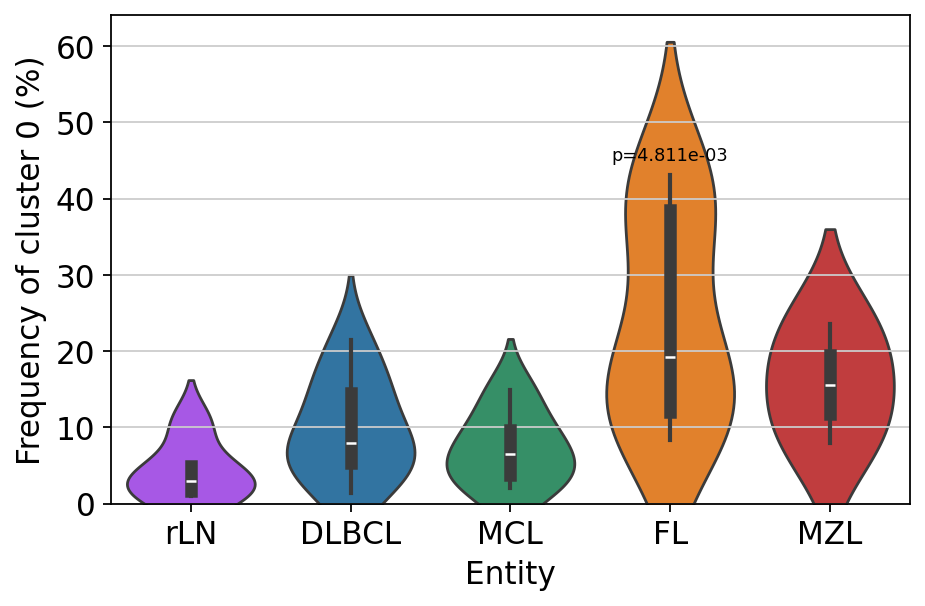

In [32]:
cluster_oi = '0'
control = "rLN"
group_order = ['rLN', 'DLBCL', 'MCL', 'FL', 'MZL']
control_vals = res.loc[res['Entity'] == control, cluster_oi]

plt.figure(figsize=(6, 4))
sns.violinplot(res, x='Entity', y=cluster_oi, hue='Entity', inner='box', order=group_order)
plt.ylim(0, None)
plt.ylabel(f"Frequency of cluster {cluster_oi} (%)")

y_max = res[cluster_oi].max()
for i, entity in enumerate(group_order):
    if entity != control:
        p = mannwhitneyu(control_vals, res.loc[res['Entity'] == entity, cluster_oi]).pvalue
        if p < 0.05:
            plt.text(i, y_max + 2, f"p={p:.3e}", ha='center', fontsize=8)

plt.tight_layout()
plt.show()

This analysis demonstrates that we indeed retrieved T cell states that were differentially abundant for the lymphoma entity. In a last step we compute the confusion matrix with the predicted cell type labels in order to assign these cells to a canonical T cell lineage.

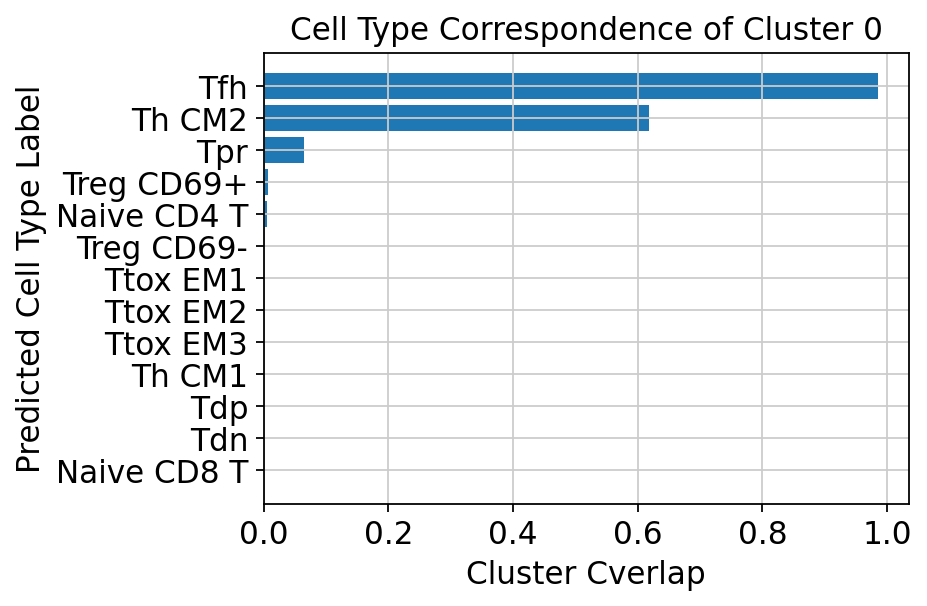

In [33]:
conf_mtx = sc.metrics.confusion_matrix(adata.obs['cell_type_predicted'], adata.obs['da_cluster'])
conf_clust_oi = conf_mtx[cluster_oi].sort_values()

plt.figure(figsize=(6, 4))
plt.barh(conf_clust_oi.index, conf_clust_oi.values)
plt.xlabel("Cluster Cverlap")
plt.ylabel("Predicted Cell Type Label")
plt.title(f"Cell Type Correspondence of Cluster {cluster_oi}")
plt.tight_layout()
plt.show()

This analysis demonstrates that the differentially abundant T cell cluster we identified using our label-free DA analysis appear to be mainly comprised of T follicular helper cells - a subpopulation of T helper cells that stimulate B cell responses and has been associated with Follicular Lymphoma in the original study by Roider et al.